In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import pandas as pd 
import numpy as np 
import seaborn as sns
import random 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing

tfk = tf.keras
tfkl = tf.keras.layers

Num GPUs Available:  1


In [2]:
BATCH_SIZE = 32
SHAPE = (4096, 23)
BLOCK_SHAPE = (64, 23)
EPOCHS = 30
VARIABLES = 23
NFOLD = 5 
STEPS_PER_EPOCH = 200
ID = 28

In [3]:
if ID == 28:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C28.csv'
elif ID == 37:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C37.csv'
else:
    print('Invalid ID')
df_test = pd.read_csv(file, nrows=100)
float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float16 for c in float_cols}

df = pd.read_csv(file, dtype=float32_cols, engine='c')
df['id'] = df.id.astype('int32')
df = df.dropna()

In [4]:
sources = df[['id', 'plane_id', 'split', 'date_diff', 'before_after']].drop_duplicates()
sources.loc[: , ['split', 'before_after', 'id']].groupby(['split', 'before_after']).count()

id
split before_after     
0     0             589
      1             484
1     0             555
      1             449
2     0             641
      1             552
3     0             343
      1             282
4     0             456
      1             382

In [5]:
input_columns = ['volt1',
 'volt2',
 'amp1',
 'amp2',
 'FQtyL',
 'FQtyR',
 'E1 FFlow',
 'E1 OilT',
 'E1 OilP',
 'E1 RPM',
 'E1 CHT1',
 'E1 CHT2',
 'E1 CHT3',
 'E1 CHT4',
 'E1 EGT1',
 'E1 EGT2',
 'E1 EGT3',
 'E1 EGT4',
 'OAT',
 'IAS',
 'VSpd',
 'NormAc',
 'AltMSL']

In [6]:
preprocess = preprocessing.MinMaxScaler()
preprocess.fit(df.loc[:, input_columns].sample(100000, random_state = 0 ))
org_value = df.loc[:, input_columns].values
res = preprocess.transform(org_value)
for i, col in enumerate(input_columns):
    df.loc[:, col] = res[:, i]

D:\Python-Anaconda\envs\tf\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [7]:
def get_dataset(df): 

    ids = df.id.unique()

    sensor_datas = []
    afters = [] 

    for id in ids: 
        sensor_data = df[df.id == id].iloc[-SHAPE[0]:, :23].values

        sensor_data = np.pad(sensor_data, [[0, SHAPE[0]- len(sensor_data)], [0,0]])

        sensor_data = tf.convert_to_tensor(sensor_data, dtype = tf.float32) 

        after = df[df.id == id]['before_after'].iloc[0]

        sensor_datas.append(sensor_data)
        afters.append(after)


    sensor_datas = tf.stack(sensor_datas)
    afters = np.stack(afters)

    ds = tf.data.Dataset.from_tensor_slices( (sensor_datas, afters))
    
    return ds

In [8]:
def slice_random(x, y):
    start = tf.random.uniform(shape=[], minval=0, maxval=4096-BLOCK_SHAPE[0], dtype=tf.int64)
    x = x[start: start + BLOCK_SHAPE[0]]
    x = tf.reshape(x, (BLOCK_SHAPE))
    return x, y 

In [9]:
def fix_type(x, y):

    return tf.cast(x, tf.float32), tf.cast(y, tf.float32)

In [10]:
def prepare_for_training(ds, shuffle = False, repeat = False, predict= True):
    
    ds = ds.map(fix_type)
    ds = ds.map(slice_random)

    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds 
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)

    if not predict: 
        ds = ds.map(lambda x, y : (x, x) ) 
    else: 
        ds = ds.map(lambda x, y : (x, tf.reshape(y, (-1, 1))) )
         
    return ds

In [11]:
def get_train_and_val_for_fold(folded_datasets, fold):
    predict = True

    train = []
    for i in range(NFOLD-1): 
        if i == fold:
            val_ds = folded_datasets[i][0].concatenate(folded_datasets[i][1])
        else: 
            train.append(folded_datasets[i][0])
    
    test_ds = folded_datasets[4][0].concatenate(folded_datasets[4][1])
    
    train_ds = None
    for ds in train: 
        train_ds = ds if train_ds is None else train_ds.concatenate(ds)

    test_ds = prepare_for_training(test_ds, shuffle=False)
    train_ds = prepare_for_training(train_ds, shuffle=True, repeat = True)
    val_ds = prepare_for_training(val_ds, shuffle=False)
    
    return train_ds, val_ds, test_ds

In [12]:
folded_datasets = []

for i in range(NFOLD):
    after = get_dataset(df[(df.split == i) & (df.before_after == 1)])
    before = get_dataset(df[(df.split == i) & (df.before_after == 0)])
    folded_datasets.append((after, before))

In [13]:
class Autoencoder(tfk.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tfk.Sequential([
            tfkl.Input(shape = BLOCK_SHAPE),
            tfkl.Conv1D(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Dropout(0.5),
            tfkl.Conv1D(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Dropout(0.5),
            tfkl.Conv1D(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Dropout(0.5),
            tfkl.Conv1D(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
        ])
        
        self.decoder = tf.keras.Sequential([
            tfkl.Conv1DTranspose(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(64, kernel_size= 7, strides= 2, activation='relu', padding='same'),
            tfkl.Conv1D(1, kernel_size = 3, activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [14]:
class Conv1D(tfk.Model):
    def __init__(self):
        super(Conv1D, self).__init__()
        self.conv1D_model = tfk.Sequential([
            tfkl.Input(shape = BLOCK_SHAPE),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.Conv1D(64, kernel_size= 7, strides=2, activation='relu', padding='same'),
            tfkl.GlobalAveragePooling1D(),
            tfkl.Dense(1, activation='sigmoid'),
        ])
            
    def call(self, x):
        conv1D = self.conv1D_model(x)
        return conv1D

In [15]:
cnn1D_encoder_result = {}
for i in range(NFOLD-1):
    autoencoder = Autoencoder()
    autoencoder.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', 
                                   tfk.metrics.RootMeanSquaredError(),
                                  ],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = autoencoder.fit(train_dataset, epochs= EPOCHS,steps_per_epoch = STEPS_PER_EPOCH,validation_data= val_dataset,)
    
    cnn1D_encoder_result[i] = result.history

pd.DataFrame(cnn1D_encoder_result)

Epoch 1/30
200/200 [==============================] - 22s 14ms/step - loss: 0.2452 - accuracy: 0.7541 - root_mean_squared_error: 0.4952 - val_loss: 0.2503 - val_accuracy: 0.4711 - val_root_mean_squared_error: 0.5003
Epoch 2/30
200/200 [==============================] - 2s 12ms/step - loss: 0.2412 - accuracy: 0.8614 - root_mean_squared_error: 0.4911 - val_loss: 0.2505 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.5005
Epoch 3/30
200/200 [==============================] - 2s 12ms/step - loss: 0.2345 - accuracy: 0.9447 - root_mean_squared_error: 0.4843 - val_loss: 0.2511 - val_accuracy: 0.4611 - val_root_mean_squared_error: 0.5011
Epoch 4/30
200/200 [==============================] - 2s 12ms/step - loss: 0.2236 - accuracy: 0.9880 - root_mean_squared_error: 0.4729 - val_loss: 0.2522 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5022
Epoch 5/30
200/200 [==============================] - 2s 12ms/step - loss: 0.2058 - accuracy: 0.9987 - root_mean_squared_error: 0.4536 - va

200/200 [==============================] - 2s 12ms/step - loss: 0.1240 - accuracy: 1.0000 - root_mean_squared_error: 0.3522 - val_loss: 0.2877 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5363
Epoch 9/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0851 - accuracy: 1.0000 - root_mean_squared_error: 0.2918 - val_loss: 0.3194 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5652
Epoch 10/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0567 - accuracy: 1.0000 - root_mean_squared_error: 0.2380 - val_loss: 0.3551 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5959
Epoch 11/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0417 - accuracy: 1.0000 - root_mean_squared_error: 0.2041 - val_loss: 0.3840 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6197
Epoch 12/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0314 - accuracy: 1.0000 - root_mean_squared_error: 0.1771 - val_loss: 0

200/200 [==============================] - 3s 13ms/step - loss: 0.0163 - accuracy: 1.0000 - root_mean_squared_error: 0.1276 - val_loss: 0.4500 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6709
Epoch 16/30
200/200 [==============================] - 3s 13ms/step - loss: 0.0154 - accuracy: 1.0000 - root_mean_squared_error: 0.1242 - val_loss: 0.4628 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6803
Epoch 17/30
200/200 [==============================] - 3s 13ms/step - loss: 0.0145 - accuracy: 1.0000 - root_mean_squared_error: 0.1204 - val_loss: 0.4751 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6893
Epoch 18/30
200/200 [==============================] - 3s 13ms/step - loss: 0.0130 - accuracy: 1.0000 - root_mean_squared_error: 0.1141 - val_loss: 0.4782 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6915
Epoch 19/30
200/200 [==============================] - 3s 13ms/step - loss: 0.0123 - accuracy: 1.0000 - root_mean_squared_error: 0.1109 - val_loss: 

200/200 [==============================] - 2s 12ms/step - loss: 0.0108 - accuracy: 1.0000 - root_mean_squared_error: 0.1037 - val_loss: 0.5070 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7120
Epoch 24/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0098 - accuracy: 1.0000 - root_mean_squared_error: 0.0992 - val_loss: 0.5202 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7213
Epoch 25/30
200/200 [==============================] - 2s 11ms/step - loss: 0.0093 - accuracy: 1.0000 - root_mean_squared_error: 0.0962 - val_loss: 0.5139 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7169
Epoch 26/30
200/200 [==============================] - 2s 11ms/step - loss: 0.0081 - accuracy: 1.0000 - root_mean_squared_error: 0.0903 - val_loss: 0.5165 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7187
Epoch 27/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0088 - accuracy: 1.0000 - root_mean_squared_error: 0.0938 - val_loss: 

,0,1,2,3
loss,"[0.24524511396884918, 0.2411632090806961, 0.23...","[0.25036871433258057, 0.24767562747001648, 0.2...","[0.24725428223609924, 0.2447834461927414, 0.24...","[0.25044673681259155, 0.24905040860176086, 0.2..."
accuracy,"[0.7540649175643921, 0.8613622784614563, 0.944...","[0.41139891743659973, 0.6248754858970642, 0.84...","[0.8960351347923279, 0.9801806807518005, 0.998...","[0.4451220631599426, 0.6271069049835205, 0.791..."
root_mean_squared_error,"[0.4952223002910614, 0.49108371138572693, 0.48...","[0.5003685355186462, 0.4976702034473419, 0.493...","[0.4972466826438904, 0.49475595355033875, 0.49...","[0.5004465579986572, 0.49904951453208923, 0.49..."
val_loss,"[0.2502596080303192, 0.2504698932170868, 0.251...","[0.2500837445259094, 0.25023555755615234, 0.25...","[0.2500931918621063, 0.250180721282959, 0.2504...","[0.25002774596214294, 0.25008827447891235, 0.2..."
val_accuracy,"[0.47108784317970276, 0.46379321813583374, 0.4...","[0.4854460656642914, 0.4643239676952362, 0.454...","[0.46657252311706543, 0.46621620655059814, 0.4...","[0.48918071389198303, 0.4768194854259491, 0.46..."
val_root_mean_squared_error,"[0.500259518623352, 0.5004696846008301, 0.5010...","[0.5000836849212646, 0.5002354979515076, 0.500...","[0.5000931620597839, 0.5001806616783142, 0.500...","[0.5000277161598206, 0.5000882744789124, 0.500..."


In [16]:
cnnv1D_result = {}
for i in range(NFOLD-1):
    conv1D = Conv1D()
    conv1D.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', tfk.metrics.RootMeanSquaredError(),],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = conv1D.fit(train_dataset, epochs= EPOCHS,steps_per_epoch = STEPS_PER_EPOCH,validation_data= val_dataset,)
    
    cnnv1D_result[i] = result.history

pd.DataFrame(cnnv1D_result)

Epoch 1/30
200/200 [==============================] - 2s 8ms/step - loss: 0.2339 - accuracy: 0.9887 - root_mean_squared_error: 0.4837 - val_loss: 0.2527 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5027
Epoch 2/30
200/200 [==============================] - 2s 8ms/step - loss: 0.2135 - accuracy: 1.0000 - root_mean_squared_error: 0.4621 - val_loss: 0.2578 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5078
Epoch 3/30
200/200 [==============================] - 2s 8ms/step - loss: 0.1897 - accuracy: 1.0000 - root_mean_squared_error: 0.4355 - val_loss: 0.2639 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5138
Epoch 4/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1651 - accuracy: 1.0000 - root_mean_squared_error: 0.4063 - val_loss: 0.2714 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5210
Epoch 5/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1403 - accuracy: 1.0000 - root_mean_squared_error: 0.3746 - val_loss

200/200 [==============================] - 1s 7ms/step - loss: 0.0778 - accuracy: 1.0000 - root_mean_squared_error: 0.2789 - val_loss: 0.3361 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5797
Epoch 10/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0607 - accuracy: 1.0000 - root_mean_squared_error: 0.2464 - val_loss: 0.3571 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5976
Epoch 11/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0478 - accuracy: 1.0000 - root_mean_squared_error: 0.2187 - val_loss: 0.3748 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6122
Epoch 12/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0375 - accuracy: 1.0000 - root_mean_squared_error: 0.1936 - val_loss: 0.3945 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.6281
Epoch 13/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0299 - accuracy: 1.0000 - root_mean_squared_error: 0.1729 - val_loss: 0.410

Epoch 17/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0122 - accuracy: 1.0000 - root_mean_squared_error: 0.1105 - val_loss: 0.4829 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6949
Epoch 18/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0123 - accuracy: 1.0000 - root_mean_squared_error: 0.1107 - val_loss: 0.4880 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6985
Epoch 19/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0114 - accuracy: 1.0000 - root_mean_squared_error: 0.1066 - val_loss: 0.4926 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.7019
Epoch 20/30
200/200 [==============================] - 2s 8ms/step - loss: 0.0109 - accuracy: 1.0000 - root_mean_squared_error: 0.1046 - val_loss: 0.4944 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.7031
Epoch 21/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0101 - accuracy: 1.0000 - root_mean_squared_error: 0.1005 - val

200/200 [==============================] - 1s 7ms/step - loss: 0.0099 - accuracy: 1.0000 - root_mean_squared_error: 0.0996 - val_loss: 0.5039 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7098
Epoch 26/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0100 - accuracy: 1.0000 - root_mean_squared_error: 0.1001 - val_loss: 0.5063 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7115
Epoch 27/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0099 - accuracy: 1.0000 - root_mean_squared_error: 0.0997 - val_loss: 0.5090 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7135
Epoch 28/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0089 - accuracy: 1.0000 - root_mean_squared_error: 0.0943 - val_loss: 0.5120 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7156
Epoch 29/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0094 - accuracy: 1.0000 - root_mean_squared_error: 0.0970 - val_loss: 0.509

,0,1,2,3
loss,"[0.2339443415403366, 0.21350617706775665, 0.18...","[0.2704378068447113, 0.24188536405563354, 0.21...","[0.17879563570022583, 0.1493791937828064, 0.12...","[0.28456196188926697, 0.2560829222202301, 0.22..."
accuracy,"[0.9887499809265137, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.046406250447034836, 0.7796875238418579, 0.9...","[0.9993749856948853, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.03703124821186066, 0.3101562559604645, 0.98..."
root_mean_squared_error,"[0.4836779236793518, 0.46206727623939514, 0.43...","[0.5200363397598267, 0.4918184280395508, 0.462...","[0.4228423237800598, 0.38649603724479675, 0.34...","[0.5334435105323792, 0.5060463547706604, 0.477..."
val_loss,"[0.25273293256759644, 0.2578267455101013, 0.26...","[0.24916644394397736, 0.25287342071533203, 0.2...","[0.26572370529174805, 0.2784543037414551, 0.29...","[0.24913915991783142, 0.2506178915500641, 0.25..."
val_accuracy,"[0.4583333432674408, 0.4583333432674408, 0.458...","[0.5403226017951965, 0.4495967626571655, 0.450...","[0.46621620655059814, 0.46621620655059814, 0.4...","[0.5328947305679321, 0.4802631437778473, 0.463..."
val_root_mean_squared_error,"[0.5027254819869995, 0.5077664256095886, 0.513...","[0.49916574358940125, 0.502865195274353, 0.507...","[0.5154839158058167, 0.527687668800354, 0.5436...","[0.49913841485977173, 0.500617504119873, 0.504..."


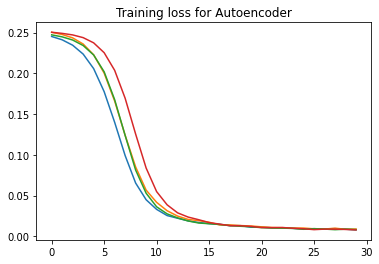

In [17]:
for i in range(NFOLD-1):
    loss = cnn1D_encoder_result[i]['loss']
    plt.plot(loss)
    plt.title('Training loss for Autoencoder')

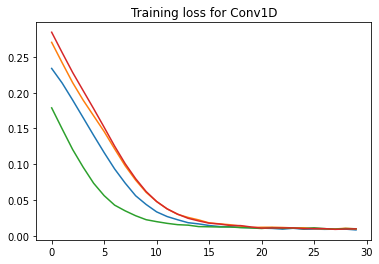

In [18]:
for i in range(NFOLD-1):
    loss = cnnv1D_result[i]['loss']
    plt.plot(loss)
    plt.title('Training loss for Conv1D')

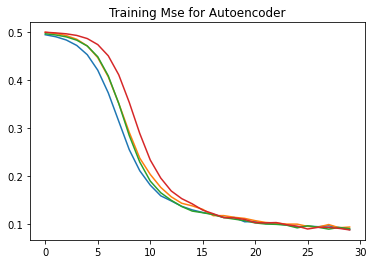

In [19]:
for i in range(NFOLD-1):
    mse = cnn1D_encoder_result[i]['root_mean_squared_error']
    plt.plot(mse)
    plt.title('Training Mse for Autoencoder')

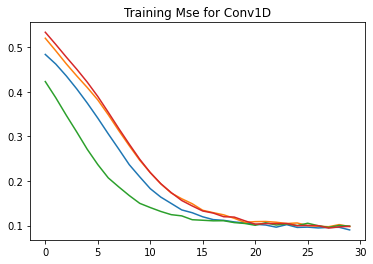

In [20]:
for i in range(NFOLD-1):
    mse = cnnv1D_result[i]['root_mean_squared_error']
    plt.plot(mse)
    plt.title('Training Mse for Conv1D')

26/26 [==============================] - 1s 3ms/step


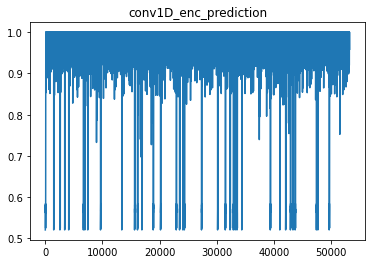

In [21]:
cnn1D_enc_predict = autoencoder.predict(test_dataset, verbose = True)
cnn1D_enc_predict = cnn1D_enc_predict.reshape(-1)
plt.title("conv1D_enc_prediction")
plt.plot(cnn1D_enc_predict)

53248


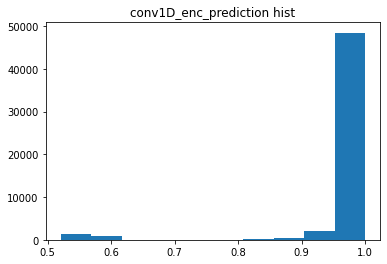

In [22]:
plt.title("conv1D_enc_prediction hist")
plt.hist(cnn1D_enc_predict)
print(cnn1D_enc_predict.size)

26/26 [==============================] - 0s 2ms/step


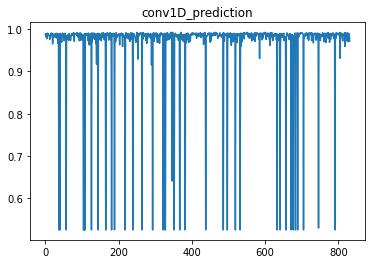

In [23]:
conv1D_predict = conv1D.predict(test_dataset, verbose = True)
plt.title("conv1D_prediction")
plt.plot(conv1D_predict)

832


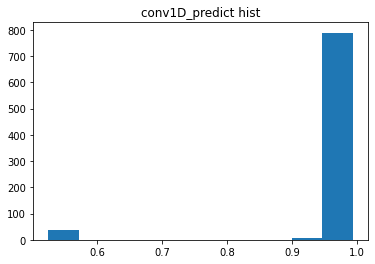

In [24]:
plt.title("conv1D_predict hist")
plt.hist(conv1D_predict)
print(conv1D_predict.size)